# Simulation: Expressive Power of GNNs

Dans ce notebook, nous validons par des résultats expérimentaux, la théorie développée dans le rapport. 
Pour ce faire, nous réalisons les étapes suivantes:

- Génération d'un graphe pour l'entraînement du modèle avec des labels réalisant la fonction détaillée dans la partie 4 du rapport.
- Entraînement de divers modèles de GNNs sur ce graphe.
- Comparaison de la fonction produite avec la fonction réelle.

## Génération du graphe

In [1]:
# Requirements

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, ChebConv
from torch_geometric.utils import from_networkx

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Nous fixons les paramètres suivants pour le graphe et les GNNs utilisés.

In [33]:
# Paramètres de base
n_nodes = 1000
latent_dim = 2
scaling_factor = 2.5
n_epochs = 1000
learning_rate = 0.1

Nous générons un graphe à partir d'un modèle usuel de graphe à variables latentes.

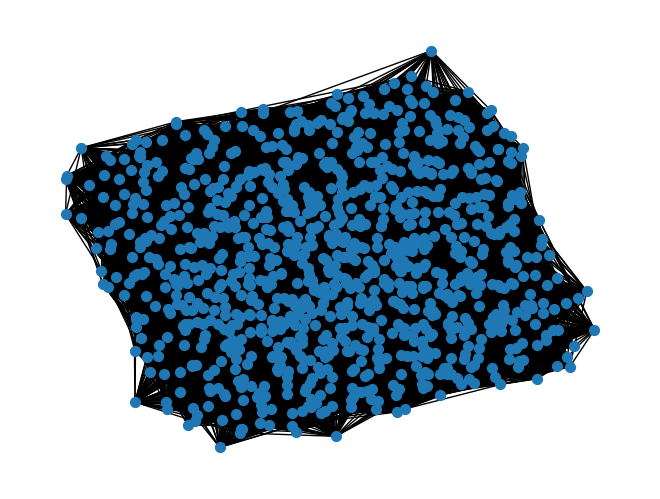

In [34]:
def generate_latent_variable_graph(n_nodes, latent_dim, scaling_factor):
    latent_variables = np.random.uniform(-1, 1, (n_nodes, latent_dim))
    G = nx.Graph()
    G.add_nodes_from(range(n_nodes))
    for i in range(n_nodes):
        for j in range(i + 1, n_nodes):
            dist = np.linalg.norm(latent_variables[i] - latent_variables[j])
            p_ij = sigmoid(scaling_factor * dist)
            if np.random.rand() > p_ij:
                G.add_edge(i, j)
    return G, latent_variables

G, latent_variables = generate_latent_variable_graph(n_nodes, latent_dim, scaling_factor)

# Visualisation du graphe généré
nx.draw(G, node_size=20)
plt.show()

Ensuite, nous générons des labels à partir de features aléatoires du graphe. Les labels réalisent la fonction suivante sur les noeuds:

\begin{equation}
    h(node_i) = cos(AX_{(i,:)})
\end{equation}

avec A la matrice d'adjacence du graphe. Pour ce faire, nous aggrégeons les features de noeuds voisins et appliquons la fonction régulière cosinus à cette aggrégation.

In [35]:
node_features = np.random.uniform(-1, 1, (n_nodes, latent_dim))
A = nx.adjacency_matrix(G).todense()
aggregated_features = A @ node_features
combined_features = aggregated_features + node_features

def generate_labels_from_aggregation(features):
    return np.cos(np.linalg.norm(features, axis=1))

node_labels_from_aggregation = generate_labels_from_aggregation(combined_features)

data = from_networkx(G)
data.x = torch.tensor(node_features, dtype=torch.float)
data.y = torch.tensor(node_labels_from_aggregation, dtype=torch.float)


## Définition des modèles de GNNs utilisés

Nous utilisons 5 modèles de ConvGNNs: 

- GCN avec 3 layers de convolution
- GCN avec 1 layer de convolution et un layer de MLP
- GraphSAGE avec 1 layer de convolution et un layer de MLP
- ChebNet avec 1 layer de convolution et un layer de MLP
- Graph Attention Network avec 1 layer de convolution et un layer de MLP


Pour commencer, nous évaluons uniquemeent les performances du 2ème modèle, pour s'assurer de l'adéquation de nos données.

Epoch 0, Loss: 0.5072989463806152
Epoch 10, Loss: 0.49202221632003784
Epoch 20, Loss: 0.4887344241142273
Epoch 30, Loss: 0.4855196475982666
Epoch 40, Loss: 0.48204144835472107
Epoch 50, Loss: 0.4772151708602905
Epoch 60, Loss: 0.4706399142742157
Epoch 70, Loss: 0.46264997124671936
Epoch 80, Loss: 0.45247945189476013
Epoch 90, Loss: 0.44442054629325867
Epoch 100, Loss: 0.43931037187576294
Epoch 110, Loss: 0.4321472942829132
Epoch 120, Loss: 0.424707293510437
Epoch 130, Loss: 0.41977113485336304
Epoch 140, Loss: 0.4107872247695923
Epoch 150, Loss: 0.40707510709762573
Epoch 160, Loss: 0.4040290117263794
Epoch 170, Loss: 0.3981640040874481
Epoch 180, Loss: 0.3954422175884247
Epoch 190, Loss: 0.3926485478878021
Epoch 200, Loss: 0.38858723640441895
Epoch 210, Loss: 0.3882065713405609
Epoch 220, Loss: 0.38613367080688477
Epoch 230, Loss: 0.3819880187511444
Epoch 240, Loss: 0.37876150012016296
Epoch 250, Loss: 0.3781280219554901
Epoch 260, Loss: 0.37682512402534485
Epoch 270, Loss: 0.375313639

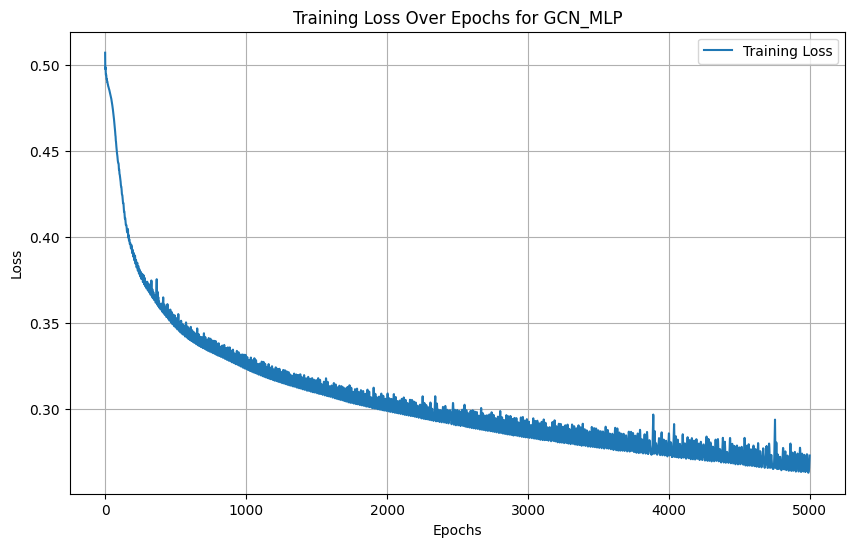

In [40]:
class GCN_MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, mlp_hidden_channels, out_channels):
        super(GCN_MLP, self).__init__()
        # Un seul layer GCN
        self.gcn = GCNConv(in_channels, hidden_channels)
        
        # MLP: plusieurs couches fully connected
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels, mlp_hidden_channels),
            nn.ReLU(),
            nn.Linear(mlp_hidden_channels, out_channels)
        )
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Passage par GCN
        x = self.gcn(x, edge_index)
        x = torch.relu(x)  # Activation après la convolution
        
        # Passage par le MLP
        x = self.mlp(x)
        
        return x

# Initialisation du modèle
in_channels = data.num_features
hidden_channels = 128
mlp_hidden_channels = 256
out_channels = 1  # Une seule sortie par nœud (pour la régression)

# Initialisation du modèle
model = GCN_MLP(in_channels, hidden_channels, mlp_hidden_channels, out_channels)

# Fonction de perte (MSE pour minimiser la différence avec les labels)
criterion = nn.MSELoss()

# Optimiseur Adam pour l'entraînement
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Fonction d'entraînement modifiée pour tracer la loss
def train_model(model, data, criterion, optimizer, epochs=200):
    model.train()
    loss_values = []  # Liste pour stocker les valeurs de perte
    for epoch in range(epochs):
        optimizer.zero_grad()  # Réinitialiser les gradients
        out = model(data)  # Prédictions
        loss = criterion(out.view(-1), data.y)  # Calcul de la loss
        loss.backward()  # Rétropropagation
        optimizer.step()  # Mise à jour des poids
        
        loss_values.append(loss.item())  # Stocker la perte
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    return loss_values  # Retourner les valeurs de perte

# Appel d'entraînement avec le bon nom de fonction
loss_history = train_model(model, data, criterion, optimizer, epochs=5000)

# Tracer la perte
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs for GCN_MLP')
plt.grid(True)
plt.legend()
plt.show()

Epoch 0, Loss: 0.4980175793170929
Epoch 10, Loss: 0.4885290861129761
Epoch 20, Loss: 0.4846675395965576
Epoch 30, Loss: 0.4793608486652374
Epoch 40, Loss: 0.4730220437049866
Epoch 50, Loss: 0.4658367335796356
Epoch 60, Loss: 0.45696139335632324
Epoch 70, Loss: 0.44916224479675293
Epoch 80, Loss: 0.441688597202301
Epoch 90, Loss: 0.4333907663822174
Epoch 100, Loss: 0.42590802907943726
Epoch 110, Loss: 0.4204224646091461
Epoch 120, Loss: 0.4133393466472626
Epoch 130, Loss: 0.40820416808128357
Epoch 140, Loss: 0.4039671719074249
Epoch 150, Loss: 0.3975529372692108
Epoch 160, Loss: 0.39216339588165283
Epoch 170, Loss: 0.41190409660339355
Epoch 180, Loss: 0.3923145532608032
Epoch 190, Loss: 0.38251742720603943
Epoch 200, Loss: 0.3794235289096832
Epoch 210, Loss: 0.3760945498943329
Epoch 220, Loss: 0.3731957972049713
Epoch 230, Loss: 0.3704109191894531
Epoch 240, Loss: 0.37138229608535767
Epoch 250, Loss: 0.36922696232795715
Epoch 260, Loss: 0.36702725291252136
Epoch 270, Loss: 0.36261412501

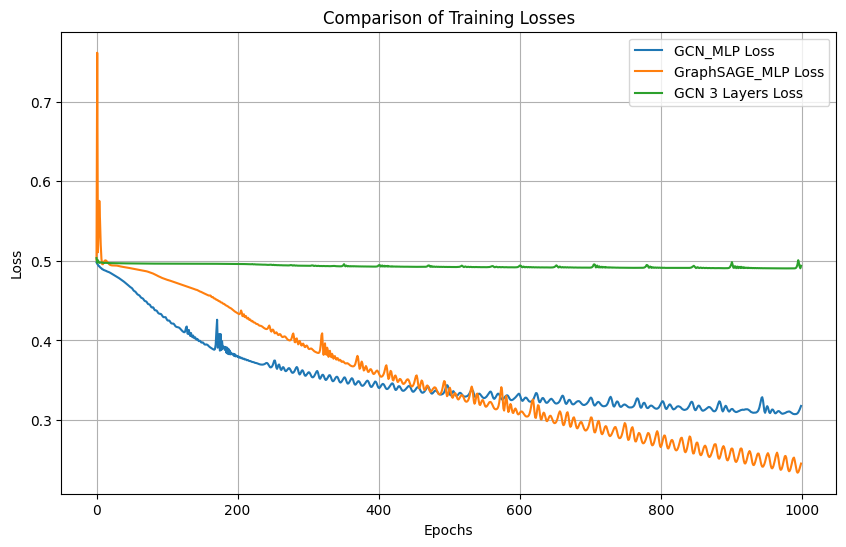

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.data import Data

# Modèle GCN avec MLP
class GCN_MLP(nn.Module):
    def __init__(self, in_channels, hidden_channels, mlp_hidden_channels, out_channels):
        super(GCN_MLP, self).__init__()
        self.gcn = GCNConv(in_channels, hidden_channels)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels, mlp_hidden_channels),
            nn.ReLU(),
            nn.Linear(mlp_hidden_channels, out_channels)
        )
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gcn(x, edge_index)
        x = torch.relu(x)
        x = self.mlp(x)
        return x

# Modèle GraphSAGE avec MLP
class GraphSAGE_MLP(nn.Module):
    def __init__(self, in_channels, hidden_channels, mlp_hidden_channels, out_channels):
        super(GraphSAGE_MLP, self).__init__()
        self.sage = SAGEConv(in_channels, hidden_channels)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels, mlp_hidden_channels),
            nn.ReLU(),
            nn.Linear(mlp_hidden_channels, out_channels)
        )
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.sage(x, edge_index)
        x = torch.relu(x)
        x = self.mlp(x)
        return x

# Modèle GCN avec 3 couches de convolution
class GCN_3Layers(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN_3Layers, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        return x

# Fonction d'entraînement pour tous les modèles
def train_model(model, data, criterion, optimizer, epochs=200):
    model.train()
    loss_values = []  # Liste pour stocker les valeurs de perte
    for epoch in range(epochs):
        optimizer.zero_grad()  # Réinitialiser les gradients
        out = model(data)  # Prédictions
        loss = criterion(out.view(-1), data.y)  # Calcul de la loss
        loss.backward()  # Rétropropagation
        optimizer.step()  # Mise à jour des poids
        
        loss_values.append(loss.item())  # Stocker la perte
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    return loss_values  # Retourner les valeurs de perte

# Initialisation des modèles
in_channels = data.num_features
hidden_channels = 128
mlp_hidden_channels = 256
out_channels = 1  # Une seule sortie par nœud (pour la régression)

# Modèle GCN_MLP
model_gcn_mlp = GCN_MLP(in_channels, hidden_channels, mlp_hidden_channels, out_channels)
optimizer_gcn_mlp = torch.optim.Adam(model_gcn_mlp.parameters(), lr=0.005)

# Modèle GraphSAGE_MLP
model_graphsage_mlp = GraphSAGE_MLP(in_channels, hidden_channels, mlp_hidden_channels, out_channels)
optimizer_graphsage_mlp = torch.optim.Adam(model_graphsage_mlp.parameters(), lr=0.005)

# Modèle GCN à 3 couches
model_gcn_3layers = GCN_3Layers(in_channels, hidden_channels, out_channels)
optimizer_gcn_3layers = torch.optim.Adam(model_gcn_3layers.parameters(), lr=0.005)

# Critère de perte
criterion = nn.MSELoss()

# Entraînement des modèles
epochs = 1000
loss_gcn_mlp = train_model(model_gcn_mlp, data, criterion, optimizer_gcn_mlp, epochs)
loss_graphsage_mlp = train_model(model_graphsage_mlp, data, criterion, optimizer_graphsage_mlp, epochs)
loss_gcn_3layers = train_model(model_gcn_3layers, data, criterion, optimizer_gcn_3layers, epochs)

# Tracer la perte
plt.figure(figsize=(10, 6))
plt.plot(loss_gcn_mlp, label='GCN_MLP Loss')
plt.plot(loss_graphsage_mlp, label='GraphSAGE_MLP Loss')
plt.plot(loss_gcn_3layers, label='GCN 3 Layers Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Training Losses')
plt.grid(True)
plt.legend()
plt.show()


Epoch 0, Loss: 0.5135369896888733
Epoch 100, Loss: 0.4419516623020172
Epoch 200, Loss: 0.38688889145851135
Epoch 300, Loss: 0.36729052662849426
Epoch 400, Loss: 0.3574395477771759
Epoch 500, Loss: 0.3460227847099304
Epoch 600, Loss: 0.3418937921524048
Epoch 700, Loss: 0.3316417932510376
Epoch 800, Loss: 0.32968851923942566
Epoch 900, Loss: 0.32779937982559204
Epoch 1000, Loss: 0.32497408986091614
Epoch 1100, Loss: 0.322746604681015
Epoch 1200, Loss: 0.3172087073326111
Epoch 1300, Loss: 0.3207349181175232
Epoch 1400, Loss: 0.313648521900177
Epoch 1500, Loss: 0.3127511739730835
Epoch 1600, Loss: 0.31029459834098816
Epoch 1700, Loss: 0.3107598125934601
Epoch 1800, Loss: 0.30612263083457947
Epoch 1900, Loss: 0.30720993876457214
Epoch 0, Loss: 0.4963024854660034
Epoch 100, Loss: 0.47576791048049927
Epoch 200, Loss: 0.435771107673645
Epoch 300, Loss: 0.4055303931236267
Epoch 400, Loss: 0.37843212485313416
Epoch 500, Loss: 0.35246211290359497
Epoch 600, Loss: 0.33180978894233704
Epoch 700, Lo

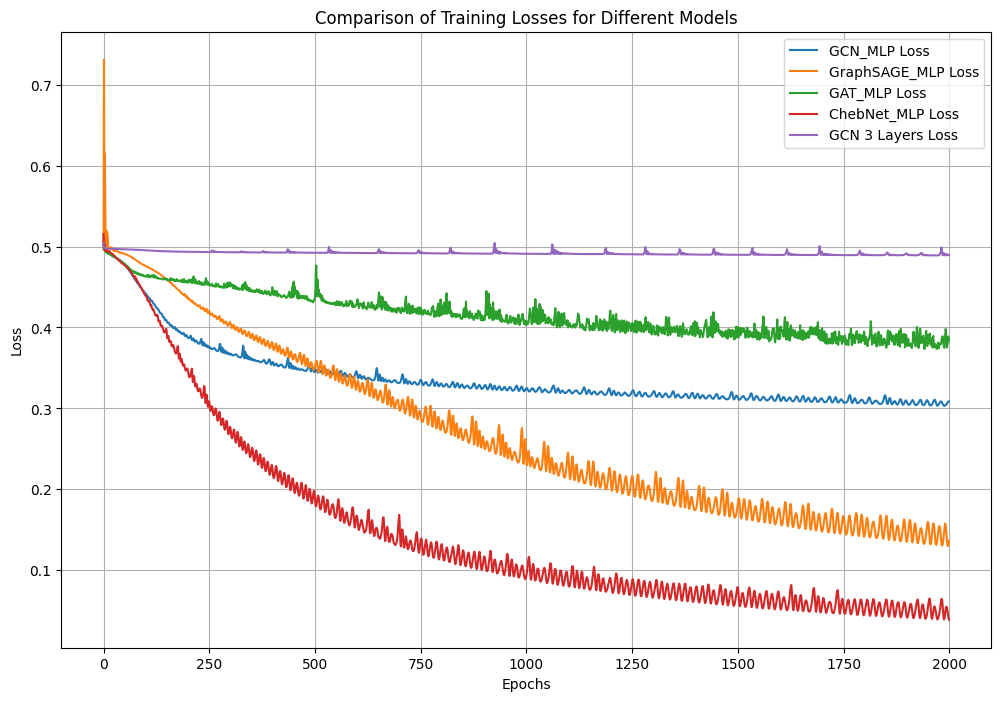

In [42]:
# Modèle GCN avec MLP
class GCN_MLP(nn.Module):
    def __init__(self, in_channels, hidden_channels, mlp_hidden_channels, out_channels):
        super(GCN_MLP, self).__init__()
        self.gcn = GCNConv(in_channels, hidden_channels)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels, mlp_hidden_channels),
            nn.ReLU(),
            nn.Linear(mlp_hidden_channels, out_channels)
        )
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gcn(x, edge_index)
        x = torch.relu(x)
        x = self.mlp(x)
        return x

# Modèle GraphSAGE avec MLP
class GraphSAGE_MLP(nn.Module):
    def __init__(self, in_channels, hidden_channels, mlp_hidden_channels, out_channels):
        super(GraphSAGE_MLP, self).__init__()
        self.sage = SAGEConv(in_channels, hidden_channels)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels, mlp_hidden_channels),
            nn.ReLU(),
            nn.Linear(mlp_hidden_channels, out_channels)
        )
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.sage(x, edge_index)
        x = torch.relu(x)
        x = self.mlp(x)
        return x

# Modèle GAT avec MLP
class GAT_MLP(nn.Module):
    def __init__(self, in_channels, hidden_channels, mlp_hidden_channels, out_channels):
        super(GAT_MLP, self).__init__()
        self.gat = GATConv(in_channels, hidden_channels)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels, mlp_hidden_channels),
            nn.ReLU(),
            nn.Linear(mlp_hidden_channels, out_channels)
        )
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gat(x, edge_index)
        x = torch.relu(x)
        x = self.mlp(x)
        return x

# Modèle ChebNet avec MLP
class ChebNet_MLP(nn.Module):
    def __init__(self, in_channels, hidden_channels, mlp_hidden_channels, out_channels, K):
        super(ChebNet_MLP, self).__init__()
        self.cheb = ChebConv(in_channels, hidden_channels, K)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels, mlp_hidden_channels),
            nn.ReLU(),
            nn.Linear(mlp_hidden_channels, out_channels)
        )
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.cheb(x, edge_index)
        x = torch.relu(x)
        x = self.mlp(x)
        return x

# Modèle GCN avec 3 couches de convolution
class GCN_3Layers(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN_3Layers, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        return x

# Fonction d'entraînement pour tous les modèles
def train_model(model, data, criterion, optimizer, epochs=200):
    model.train()
    loss_values = []  # Liste pour stocker les valeurs de perte
    for epoch in range(epochs):
        optimizer.zero_grad()  # Réinitialiser les gradients
        out = model(data)  # Prédictions
        loss = criterion(out.view(-1), data.y)  # Calcul de la loss
        loss.backward()  # Rétropropagation
        optimizer.step()  # Mise à jour des poids
        
        loss_values.append(loss.item())  # Stocker la perte
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    return loss_values  # Retourner les valeurs de perte

# Initialisation des modèles
in_channels = data.num_features
hidden_channels = 128
mlp_hidden_channels = 256
out_channels = 1  # Une seule sortie par nœud (pour la régression)
K = 2  # Order of Chebyshev polynomial

# Modèle GCN_MLP
model_gcn_mlp = GCN_MLP(in_channels, hidden_channels, mlp_hidden_channels, out_channels)
optimizer_gcn_mlp = torch.optim.Adam(model_gcn_mlp.parameters(), lr=0.005)

# Modèle GraphSAGE_MLP
model_graphsage_mlp = GraphSAGE_MLP(in_channels, hidden_channels, mlp_hidden_channels, out_channels)
optimizer_graphsage_mlp = torch.optim.Adam(model_graphsage_mlp.parameters(), lr=0.005)

# Modèle GAT_MLP
model_gat_mlp = GAT_MLP(in_channels, hidden_channels, mlp_hidden_channels, out_channels)
optimizer_gat_mlp = torch.optim.Adam(model_gat_mlp.parameters(), lr=0.005)

# Modèle ChebNet_MLP
model_cheb_mlp = ChebNet_MLP(in_channels, hidden_channels, mlp_hidden_channels, out_channels, K)
optimizer_cheb_mlp = torch.optim.Adam(model_cheb_mlp.parameters(), lr=0.005)

# Modèle GCN à 3 couches
model_gcn_3layers = GCN_3Layers(in_channels, hidden_channels, out_channels)
optimizer_gcn_3layers = torch.optim.Adam(model_gcn_3layers.parameters(), lr=0.005)

# Critère de perte
criterion = nn.MSELoss()

# Entraînement des modèles
epochs = 2000
loss_gcn_mlp = train_model(model_gcn_mlp, data, criterion, optimizer_gcn_mlp, epochs)
loss_graphsage_mlp = train_model(model_graphsage_mlp, data, criterion, optimizer_graphsage_mlp, epochs)
loss_gat_mlp = train_model(model_gat_mlp, data, criterion, optimizer_gat_mlp, epochs)
loss_cheb_mlp = train_model(model_cheb_mlp, data, criterion, optimizer_cheb_mlp, epochs)
loss_gcn_3layers = train_model(model_gcn_3layers, data, criterion, optimizer_gcn_3layers, epochs)

# Tracer la perte
plt.figure(figsize=(12, 8))
plt.plot(loss_gcn_mlp, label='GCN_MLP Loss')
plt.plot(loss_graphsage_mlp, label='GraphSAGE_MLP Loss')
plt.plot(loss_gat_mlp, label='GAT_MLP Loss')
plt.plot(loss_cheb_mlp, label='ChebNet_MLP Loss')
plt.plot(loss_gcn_3layers, label='GCN 3 Layers Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Training Losses for Different Models')
plt.grid(True)
plt.legend()
plt.show()


### Second Function: polynomial of deg 2

Ici, nous réalisons la même expérience, mais avec un graphe réalisant la fonction de noeuds suivante:

\begin{equation}
    h(node_i) = cos(A^2 X_{(i,:)})
\end{equation}

avec A la matrice d'adjacence du graphe. Pour ce faire, nous aggrégeons 2 fois les features de noeuds voisins et appliquons la fonction régulière cosinus à cette aggrégation.

Comme pour la première expérience, nous commençons la comparaison avec 3 modèles pour évaluer les coûts des modèles. 



Training GCN...
Epoch 0, Loss: 0.5016458034515381
Epoch 10, Loss: 0.49906185269355774
Epoch 20, Loss: 0.49897322058677673
Epoch 30, Loss: 0.49895361065864563
Epoch 40, Loss: 0.4989492893218994
Epoch 50, Loss: 0.49894794821739197
Epoch 60, Loss: 0.4989473819732666
Epoch 70, Loss: 0.4989471733570099
Epoch 80, Loss: 0.4989470839500427
Epoch 90, Loss: 0.4989470839500427
Epoch 100, Loss: 0.49894702434539795
Epoch 110, Loss: 0.49894699454307556
Epoch 120, Loss: 0.49894702434539795
Epoch 130, Loss: 0.49894702434539795
Epoch 140, Loss: 0.49894699454307556
Epoch 150, Loss: 0.49894699454307556
Epoch 160, Loss: 0.49894699454307556
Epoch 170, Loss: 0.49894699454307556
Epoch 180, Loss: 0.49894699454307556
Epoch 190, Loss: 0.49894699454307556

Training GCN_MLP...
Epoch 0, Loss: 0.5060802698135376
Epoch 10, Loss: 0.4990270733833313
Epoch 20, Loss: 0.4989595115184784
Epoch 30, Loss: 0.49898993968963623
Epoch 40, Loss: 0.4989471733570099
Epoch 50, Loss: 0.49895137548446655
Epoch 60, Loss: 0.4989486932

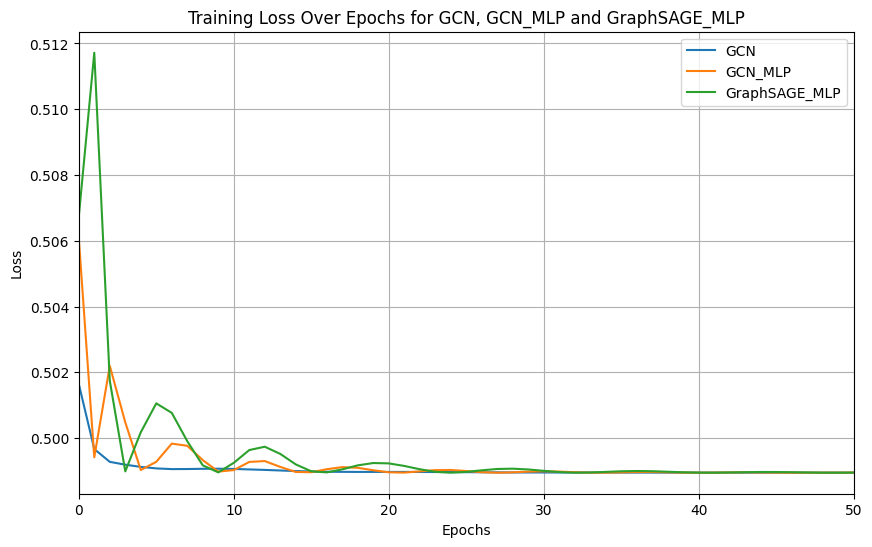

In [32]:
# Fonction sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Fonction pour générer un graphe avec variables latentes
def generate_latent_variable_graph(n_nodes, latent_dim, scaling_factor):
    latent_variables = np.random.uniform(-1, 1, (n_nodes, latent_dim))
    G = nx.Graph()
    G.add_nodes_from(range(n_nodes))
    for i in range(n_nodes):
        for j in range(i + 1, n_nodes):
            dist = np.linalg.norm(latent_variables[i] - latent_variables[j])
            p_ij = sigmoid(scaling_factor * dist)
            if np.random.rand() > p_ij:
                G.add_edge(i, j)
    return G, latent_variables

# Fonction pour générer des labels prenant en compte les 2ème voisins
def generate_labels_with_2nd_neighbors(adj_matrix, node_features):
    # Convertir la matrice d'adjacence NumPy en un tenseur PyTorch
    adj_matrix_tensor = torch.tensor(adj_matrix, dtype=torch.float32)
    
    # Passer une première fois pour agréger les features des voisins directs
    first_aggregation = adj_matrix_tensor @ node_features
    
    # Passer une deuxième fois pour agréger les voisins des voisins
    second_aggregation = adj_matrix_tensor @ first_aggregation
    
    # Appliquer une fonction régulière (par exemple, cosinus) sur la somme des features agrégées
    labels = torch.cos(torch.sum(second_aggregation, dim=1))  # cosinus de la somme des features agrégées des 2ème voisins
    return labels.view(-1, 1)

# Fonction pour normaliser les features
def normalize_features(features):
    min_val = features.min(axis=0)[0]
    max_val = features.max(axis=0)[0]
    normalized_features = (features - min_val) / (max_val - min_val)
    return normalized_features

# Classe du modèle GCN_MLP
class GCN_MLP(nn.Module):
    def __init__(self, in_channels, hidden_channels=32, mlp_hidden_channels=64, out_channels=1):
        super(GCN_MLP, self).__init__()
        # Quatre couches de convolution GCN
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        
        # MLP
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels, mlp_hidden_channels),
            nn.ReLU(),
            nn.Linear(mlp_hidden_channels, out_channels)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.mlp(x)
        return x

# Classe du modèle GraphSAGE_MLP
class GraphSAGE_MLP(nn.Module):
    def __init__(self, in_channels, hidden_channels=32, mlp_hidden_channels=64, out_channels=1):
        super(GraphSAGE_MLP, self).__init__()
        self.sage1 = SAGEConv(in_channels, hidden_channels)
        self.sage2 = SAGEConv(hidden_channels, hidden_channels)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels, mlp_hidden_channels),
            nn.ReLU(),
            nn.Linear(mlp_hidden_channels, out_channels)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.sage1(x, edge_index)
        x = F.relu(x)
        x = self.sage2(x, edge_index)
        x = F.relu(x)
        x = self.mlp(x)
        return x

# Classe du modèle GCN normal avec 4 couches
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels=32, out_channels=1):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        return x

# Fonction d'entraînement pour le modèle
def train_model(model, data, criterion, optimizer, epochs=200):
    model.train()
    loss_values = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out.view(-1), data.y)
        loss.backward()
        optimizer.step()
        
        loss_values.append(loss.item())
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    return loss_values

# Paramètres
n_nodes = 1000
latent_dim = 2
scaling_factor = 5

# Génération du graphe et des labels
G, latent_variables = generate_latent_variable_graph(n_nodes, latent_dim, scaling_factor)
A = nx.adjacency_matrix(G).todense()
node_features = np.random.uniform(-1, 1, (n_nodes, latent_dim))
normalized_node_features = normalize_features(node_features)
data = from_networkx(G)
data.x = torch.tensor(normalized_node_features, dtype=torch.float)

# Génération des labels basés sur l'agrégation des 2ème voisins
adj_matrix = A
data.y = generate_labels_with_2nd_neighbors(adj_matrix, data.x)

# Initialisation des modèles et paramètres
in_channels = data.num_features

models = {
    "GCN": GCN(in_channels, hidden_channels=32, out_channels=1),
    "GCN_MLP": GCN_MLP(in_channels, hidden_channels=32, mlp_hidden_channels=64, out_channels=1),
    "GraphSAGE_MLP": GraphSAGE_MLP(in_channels, hidden_channels=32, mlp_hidden_channels=64, out_channels=1),
}

# Optimiseur et fonction de perte
criterion = nn.MSELoss()
optimizers = {
    "GCN": optim.Adam(models["GCN"].parameters(), lr=0.01),
    "GCN_MLP": optim.Adam(models["GCN_MLP"].parameters(), lr=0.01),
    "GraphSAGE_MLP": optim.Adam(models["GraphSAGE_MLP"].parameters(), lr=0.01),
}

# Entraînement et stockage des pertes
loss_history = {model_name: [] for model_name in models.keys()}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    loss_history[model_name] = train_model(model, data, criterion, optimizers[model_name], epochs=200)

# Tracer la perte
plt.figure(figsize=(10, 6))
for model_name, losses in loss_history.items():
    plt.plot(losses, label=model_name)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs for GCN, GCN_MLP and GraphSAGE_MLP')
plt.grid(True)
plt.legend()

# Limiter l'affichage aux premiers epochs pour observer l'évolution
plt.xlim(0, 50)  # Afficher les 50 premiers epochs
plt.show()


Pour des raisons de généralisation, nous définissons un nouveau graphe réalisons la même fonction. Seuls les voisinages et les arêtes du graphe changent.


Training GCN...
Epoch 0, Loss: 0.44295018911361694
Epoch 10, Loss: 0.4415515065193176
Epoch 20, Loss: 0.44152724742889404
Epoch 30, Loss: 0.4415218234062195
Epoch 40, Loss: 0.44151943922042847
Epoch 50, Loss: 0.44151875376701355
Epoch 60, Loss: 0.44151854515075684
Epoch 70, Loss: 0.4415183961391449
Epoch 80, Loss: 0.4415183663368225
Epoch 90, Loss: 0.4415183663368225
Epoch 100, Loss: 0.4415183663368225
Epoch 110, Loss: 0.4415183663368225
Epoch 120, Loss: 0.44151830673217773
Epoch 130, Loss: 0.4415183663368225
Epoch 140, Loss: 0.4415183663368225
Epoch 150, Loss: 0.4415183663368225
Epoch 160, Loss: 0.44151830673217773
Epoch 170, Loss: 0.4415183663368225
Epoch 180, Loss: 0.4415183663368225
Epoch 190, Loss: 0.4415183663368225
Epoch 200, Loss: 0.44151830673217773
Epoch 210, Loss: 0.4415183663368225
Epoch 220, Loss: 0.44151830673217773
Epoch 230, Loss: 0.4415183663368225
Epoch 240, Loss: 0.4415183663368225
Epoch 250, Loss: 0.4415183663368225
Epoch 260, Loss: 0.4415183663368225
Epoch 270, Lo

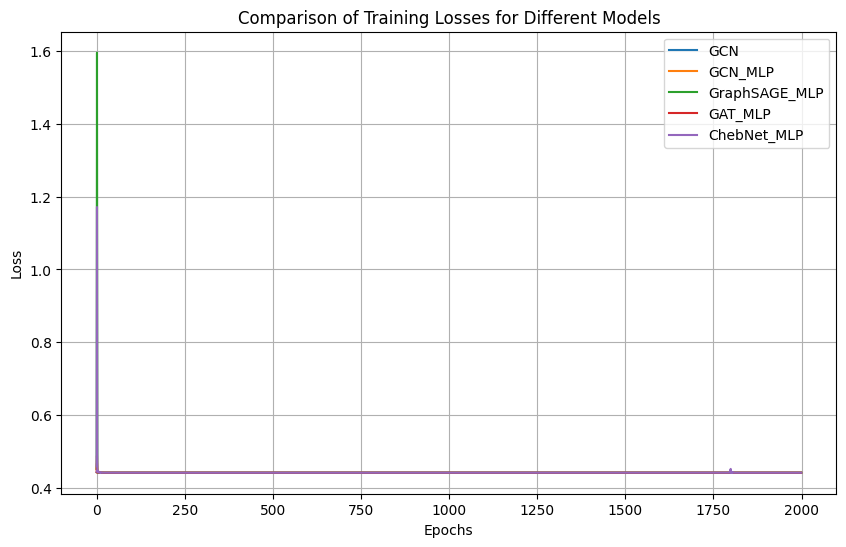

In [53]:
# Fonction sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Fonction pour générer un graphe avec variables latentes
def generate_latent_variable_graph(n_nodes, latent_dim, scaling_factor):
    latent_variables = np.random.uniform(-1, 1, (n_nodes, latent_dim))
    G = nx.Graph()
    G.add_nodes_from(range(n_nodes))
    for i in range(n_nodes):
        for j in range(i + 1, n_nodes):
            dist = np.linalg.norm(latent_variables[i] - latent_variables[j])
            p_ij = sigmoid(scaling_factor * dist)
            if np.random.rand() > p_ij:
                G.add_edge(i, j)
    return G, latent_variables

# Fonction pour générer des labels prenant en compte les 2ème voisins
def generate_labels_with_2nd_neighbors(adj_matrix, node_features):
    adj_matrix_tensor = torch.tensor(adj_matrix, dtype=torch.float32)
    first_aggregation = adj_matrix_tensor @ node_features
    second_aggregation = adj_matrix_tensor @ first_aggregation
    labels = torch.cos(torch.sum(second_aggregation, dim=1))  
    return labels.view(-1, 1)

# Fonction pour normaliser les features
def normalize_features(features):
    min_val = features.min(axis=0)[0]
    max_val = features.max(axis=0)[0]
    normalized_features = (features - min_val) / (max_val - min_val)
    return normalized_features

# Classe du modèle GCN_MLP avec 4 couches de convolution
class GCN_MLP(nn.Module):
    def __init__(self, in_channels, hidden_channels=128, mlp_hidden_channels=256, out_channels=1):
        super(GCN_MLP, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels, mlp_hidden_channels),
            nn.ReLU(),
            nn.Linear(mlp_hidden_channels, out_channels)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = self.mlp(x)
        return x

# Classe du modèle GraphSAGE_MLP avec 4 couches de convolution
class GraphSAGE_MLP(nn.Module):
    def __init__(self, in_channels, hidden_channels=128, mlp_hidden_channels=256, out_channels=1):
        super(GraphSAGE_MLP, self).__init__()
        self.sage1 = SAGEConv(in_channels, hidden_channels)
        self.sage2 = SAGEConv(hidden_channels, hidden_channels)
        self.sage3 = SAGEConv(hidden_channels, hidden_channels)
        self.sage4 = SAGEConv(hidden_channels, hidden_channels)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels, mlp_hidden_channels),
            nn.ReLU(),
            nn.Linear(mlp_hidden_channels, out_channels)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.sage1(x, edge_index)
        x = F.relu(x)
        x = self.sage2(x, edge_index)
        x = F.relu(x)
        x = self.sage3(x, edge_index)
        x = F.relu(x)
        x = self.sage4(x, edge_index)
        x = F.relu(x)
        x = self.mlp(x)
        return x

# Classe du modèle GCN normal avec 6 couches de convolution
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels=128, out_channels=1):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, hidden_channels)
        self.conv6 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = self.conv5(x, edge_index)
        x = F.relu(x)
        x = self.conv6(x, edge_index)
        return x

# Classe GAT_MLP avec 4 couches de convolution
class GAT_MLP(nn.Module):
    def __init__(self, in_channels, hidden_channels=128, mlp_hidden_channels=256, out_channels=1):
        super(GAT_MLP, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels)
        self.gat2 = GATConv(hidden_channels, hidden_channels)
        self.gat3 = GATConv(hidden_channels, hidden_channels)
        self.gat4 = GATConv(hidden_channels, hidden_channels)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels, mlp_hidden_channels),
            nn.ReLU(),
            nn.Linear(mlp_hidden_channels, out_channels)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gat1(x, edge_index)
        x = F.relu(x)
        x = self.gat2(x, edge_index)
        x = F.relu(x)
        x = self.gat3(x, edge_index)
        x = F.relu(x)
        x = self.gat4(x, edge_index)
        x = F.relu(x)
        x = self.mlp(x)
        return x

# Classe ChebNet_MLP avec 4 couches de convolution
class ChebNet_MLP(nn.Module):
    def __init__(self, in_channels, hidden_channels=128, mlp_hidden_channels=256, out_channels=1, K=2):
        super(ChebNet_MLP, self).__init__()
        self.cheb1 = ChebConv(in_channels, hidden_channels, K)
        self.cheb2 = ChebConv(hidden_channels, hidden_channels, K)
        self.cheb3 = ChebConv(hidden_channels, hidden_channels, K)
        self.cheb4 = ChebConv(hidden_channels, hidden_channels, K)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels, mlp_hidden_channels),
            nn.ReLU(),
            nn.Linear(mlp_hidden_channels, out_channels)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.cheb1(x, edge_index)
        x = F.relu(x)
        x = self.cheb2(x, edge_index)
        x = F.relu(x)
        x = self.cheb3(x, edge_index)
        x = F.relu(x)
        x = self.cheb4(x, edge_index)
        x = F.relu(x)
        x = self.mlp(x)
        return x

# Fonction d'entraînement pour le modèle
def train_model(model, data, criterion, optimizer, epochs=200):
    model.train()
    loss_values = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out.view(-1), data.y)
        loss.backward()
        optimizer.step()
        
        loss_values.append(loss.item())
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    return loss_values

# Paramètres
n_nodes = 100
latent_dim = 2
scaling_factor = 5

# Génération du graphe et des labels
G, latent_variables = generate_latent_variable_graph(n_nodes, latent_dim, scaling_factor)
A = nx.adjacency_matrix(G).todense()
node_features = np.random.uniform(-1, 1, (n_nodes, latent_dim))
normalized_node_features = normalize_features(node_features)
data = from_networkx(G)
data.x = torch.tensor(normalized_node_features, dtype=torch.float)
# Génération des labels basés sur l'agrégation des 2ème voisins
adj_matrix = A
data.y = generate_labels_with_2nd_neighbors(adj_matrix, data.x)

# Initialisation des modèles et paramètres
in_channels = data.num_features

models = {
    "GCN": GCN(in_channels, hidden_channels=128, out_channels=1),
    "GCN_MLP": GCN_MLP(in_channels, hidden_channels=100, mlp_hidden_channels=256, out_channels=1),
    "GraphSAGE_MLP": GraphSAGE_MLP(in_channels, hidden_channels=100, mlp_hidden_channels=256, out_channels=1),
    "GAT_MLP": GAT_MLP(in_channels, hidden_channels=100, mlp_hidden_channels=256, out_channels=1),
    "ChebNet_MLP": ChebNet_MLP(in_channels, hidden_channels=100, mlp_hidden_channels=256, out_channels=1, K=2),
}

# Optimiseur et fonction de perte
criterion = nn.MSELoss()
optimizers = {
    "GCN": optim.Adam(models["GCN"].parameters(), lr=0.01),
    "GCN_MLP": optim.Adam(models["GCN_MLP"].parameters(), lr=0.01),
    "GraphSAGE_MLP": optim.Adam(models["GraphSAGE_MLP"].parameters(), lr=0.01),
    "GAT_MLP": optim.Adam(models["GAT_MLP"].parameters(), lr=0.01),
    "ChebNet_MLP": optim.Adam(models["ChebNet_MLP"].parameters(), lr=0.01),
}

# Entraînement et stockage des pertes
loss_history = {model_name: [] for model_name in models.keys()}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    loss_history[model_name] = train_model(model, data, criterion, optimizers[model_name], epochs=2000)

# Tracer la perte
plt.figure(figsize=(10, 6))
for model_name, losses in loss_history.items():
    plt.plot(losses, label=model_name)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Training Losses for Different Models')
plt.grid(True)
plt.legend()
plt.show()
